In [1]:
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr
import kray
# OS interaction
import sys, pickle, os
# import subplots function for plotting
import seaborn as sns
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import kgraph
import matplotlib.gridspec as gridspec
from moviepy.editor import *

# --------------------------------------------------------------------------------------------
# Directory Lists
# Unix
if 'linux' in sys.platform:
    dirPre = '/home/lapok/gdrive/'
# Mac
elif 'darwin' in sys.platform:
    dirPre = '/Users/karllapo/gdrive/'
# Directory for printing figures
dirPrint = dirPre + 'SnowHydrology/proj/TurbulenceFeedbacks/Graphics/IR_SnoqualmieFlights'
# Met data directory
dirData = dirPre + 'SnowHydrology/proj/TurbulenceFeedbacks/data/SNQ/IR_SnoqualmieFlights'
dirDataGrobs = dirPre + 'SnowHydrology/proj/TurbulenceFeedbacks/data/SNQ/'

# --------------------------------------------------------------------------------------------
# Global formatting
sns.set_context('paper')
sns.set_style('whitegrid')
# must insert this statement to render the plots within the notebook
%matplotlib inline

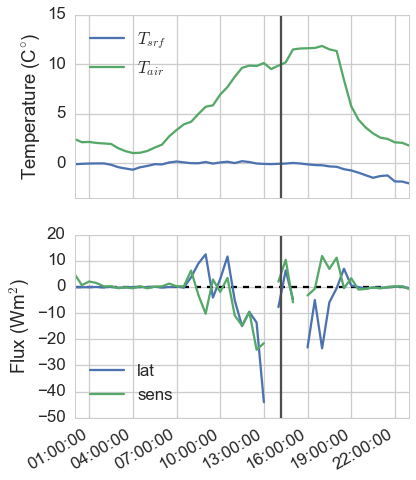

In [13]:
# Met observations
os.chdir(dirDataGrobs)
sns.set_context('talk', font_scale=1.3)
support = xr.open_dataset('SnoqualmieObs.SupportData.wy2013_wy2015.nc')

grobsDay = support.sel(time=slice('2013-05-14', '2013-05-14 23:00'))

fig, axes = plt.subplots(2, 1, figsize=(6, 8), sharex=True)

ax = axes[0]
ax.plot(grobsDay.time, grobsDay.Tsrf, label='$T_{srf}$')
ax.plot(grobsDay.time, grobsDay.T6, label='$T_{air}$')
ax.plot([d.values, d.values], [-3.5, 15], color='0.3')
ax.set_ylim(-3.5, 15)
ax.set_ylabel('Temperature (C$^{\circ}$)')
ax.legend(loc='best')

ax = axes[1]
ax.plot([grobsDay.time.values[0], grobsDay.time.values[-1]], [0, 0], 'k--')
ax.plot(grobsDay.time, grobsDay.LatFlux, label='lat')
ax.plot(grobsDay.time, grobsDay.SensFlux, label='sens')
ax.plot([d.values, d.values], [-50, 20], color='0.3')
ax.set_ylim(-50, 20)
ax.set_ylabel('Flux (Wm$^{2}$)')
ax.legend(loc='best')

fig.autofmt_xdate()
os.chdir('/Users/karllapo/gdrive/SnowHydrology/proj/TurbulenceFeedbacks/Graphics')
fig.savefig('SNQ.FlightMetObs.pdf', bbox_inches='tight')

In [ ]:
# Met observations
os.chdir(dirDataGrobs)
support = xr.open_dataset('SnoqualmieObs.SupportData.wy2013_wy2015.nc')

grobsDay = support.sel(time=slice('2013-05-14', '2013-05-14 23:00'))

fig, axes = plt.subplots(4, 1, figsize=(6, 15), sharex=True)

ax = axes[0]
ax.plot(grobsDay.time, grobsDay.Tsrf, label='$T_{srf}$')
ax.plot(grobsDay.time, grobsDay.T6, label='$T_{air}$')
ax.plot([d.values, d.values], [-3.5, 15], color='0.3')
ax.set_ylim(-3.5, 15)
ax.set_ylabel('Temperature (C$^{\circ}$)')
ax.legend(loc='best')

ax = axes[1]
ax.plot(grobsDay.time, grobsDay.WIND, label='wind')
ax.plot([d.values, d.values], [0, 3], color='0.3')
ax.set_ylim(0, 3)
ax.set_ylabel('Wind (m s$^{-1}$)')
ax.legend(loc='best')

ax = axes[2]
ax.plot(grobsDay.time, grobsDay.SW_down_avg - grobsDay.SW_up_avg, label='net SW')
ax.plot(grobsDay.time, grobsDay.LW_down_avg - grobsDay.LW_up_avg, label='net LW')
ax.plot(grobsDay.time, -grobsDay.Lysimeter * 334000, label='melt')
ax.plot([d.values, d.values], [-600, 600], color='0.3')
ax.set_ylim(-600, 600)
ax.set_ylabel('Flux (Wm$^{2}$)')
ax.legend(loc='best')

ax = axes[3]
ax.plot(grobsDay.time, grobsDay.LatFlux, label='lat')
ax.plot(grobsDay.time, grobsDay.SensFlux, label='sens')
ax.plot([d.values, d.values], [-50, 20], color='0.3')
ax.set_ylim(-50, 20)
ax.set_ylabel('Flux (Wm$^{2}$)')
ax.legend(loc='best')

fig.autofmt_xdate()

In [2]:
# --------------------------------------------------------------------------------------------
# Functions/classes for reading binary files in python
# From: http://code.activestate.com/recipes/577610-decoding-binary-files/
import struct

class BinaryReaderEOFException(Exception):
    def __init__(self):
        pass
    def __str__(self):
        return 'Not enough bytes in file to satisfy read request'

class BinaryReader:
    # Map well-known type names into struct format characters.
    typeNames = {
        'int8'   :'b',
        'uint8'  :'B',
        'int16'  :'h',
        'uint16' :'H',
        'int32'  :'i',
        'uint32' :'I',
        'int64'  :'q',
        'uint64' :'Q',
        'float'  :'f',
        'double' :'d',
        'char'   :'s'}

    def __init__(self, fileName):
        self.file = open(fileName, 'rb')
        
    def seek(self, seekLocation):
        self.file.seek(seekLocation)

    def read(self, typeName):
        typeFormat = BinaryReader.typeNames[typeName.lower()]
        typeSize = struct.calcsize(typeFormat)
        value = self.file.read(typeSize)
        if typeSize != len(value):
            raise BinaryReaderEOFException
        return struct.unpack(typeFormat, value)[0]

    def __del__(self):
        self.file.close()

In [3]:
def readInfraredCamera(fname,
                       findex=[0.],
                       params=([1904, 1904, 16, 640, 480]),
                      infoOnlyFlag=True):
    '''
    fname   - string, filename of the IR camera files. Requires a corresponding GPS/IMU and timefile
    findex  - numpy array of integers, image numbers to read
    params  - numpy array of integers, describes image
    '''
    # params - [bit_header_offset bit_spacer bit_depth width height]
    # findex - specific frames to read in
    
    # --------------------------------------------------------------------------------------------
    # get params for reading in and making data output
    info = {}
    info['hbit'] = params[0]
    info['obit'] = params[1]
    info['bit'] = params[2]
    info['bitdepth'] = info['bit']
    info['width'] = params[3]
    info['height'] = params[4]
    
    # --------------------------------------------------------------------------------------------
    # Image information
    fInfo = os.stat(fname)

    # calculated frame number
    nFrames = round((fInfo.st_size - (info['hbit'] -info['obit'])/8)
                    /((info['width'] * info['height'] * info['bitdepth'] + info['obit']) / 8)) 
    info['nframes'] = nFrames

    # --------------------------------------------------------------------------------------------
    # read time and temp from timesFile
    # Time files have the same file name as the corresponding '*.dat' files
    timeFilename = fname.split('.')[0]
    timeFilename = timeFilename + '.txt'

    # Check to see that the time file exists (nothing here yet)
    # I think the best solution here is to throw an error if no file is found.
    # The pandas 'read_csv' (below) should already give us this desired behavior

    # Read the file with time stamps and camera temperatures for each image
    timeFile = pd.read_csv(timeFilename,
                           header=None,
                           names=['epochTime',
                                  'tempName1', 'camTemp',
                                  'tempName2', 'refTemp'], 
                           index_col='epochTime')
    timeFile.drop('tempName2', axis=1, inplace=True)
    timeFile.drop('tempName1', axis=1, inplace=True)
    
    # Assumes we are reading a csv with this form:
    # 5 columnes: 1 time stamp, 4 giving camera temperatures (label1, temp1, label2, temp2)
    # "1368578461.593, 280F9A5403000002 , 8.63 , 287FE81C040000F2 , 9.19"
    # OR
    # 1 column: time stamp
    # "1368578461.593"
    #
    # Something about the temp probes was changed after April 2013 resulting in two different code
    # blocks to handle each in the original matlab code. Since all of the data I'm using is after
    # that date, I am going to ignore the code for data prior to that date

    # Each time stamp corresponds to an IR image.
    numImages = timeFile.index.size
    # Convert to numpy64 datetime objects (epochTime is in seconds since 1970)
    timeFile.index = [datetime.fromtimestamp(d) for d in timeFile.index.values]
    # exit on infoFlag
    if infoOnlyFlag:
        return(info, timeFile)
        
    # --------------------------------------------------------------------------------------------
    # Acquire IR camera images
    numFrames = fIndex.size
    info['nFrames'] = numFrames

    # There is this 'uvs' argument in the original matlab read script, but it isn't defined. This
    # variable is never used in the 'snowIR_example.m' script, so I'm going to ignore the code block
    # that handles it.
    binDataOut = np.zeros([info['height'], info['width'], info['nFrames']])
    imageSize = info['width'] * info['height']

    for j in np.arange(0, numFrames):
        # Update progress
        if numFrames > 1:
            print("\r", '%d of %d' % (j+1, numFrames), end="")

        # Discover next position in binary file
        seekBitLoc = (info['width'] * info['height'] * (info['bit'] / 8) + info['obit'] / 8) \
                     * (fIndex[j]) + info['hbit'] / 8
        seekBitLoc = int(seekBitLoc)

        # Ready binary file
        binaryReader = BinaryReader(fname)
        # Point python to the desired location in the binary file (0 means seek from beginning of file)
        binaryReader.seek(seekBitLoc)
        try:
            numBinaryItems = imageSize
            data = np.empty(numBinaryItems)
            for binIndex in np.arange(numBinaryItems):
                data[binIndex] = binaryReader.read('uint16')
            binDataOut[:, :, j] = data.reshape(info['height'], info['width'])

        except BinaryReaderEOFException:
            # One of our attempts to read a field went beyond the end of the file.
            print("Error: File seems to be corrupted.")
        
    return binDataOut, timeFile

In [4]:
import utm


def readIMU(fname):
    # Column 1 is time
    # Columns 12 and 13 are lat and lon
    # Columns 2-9 are actually column 2 in the readme and original MATLAB code - they are demarked using a semi-colon

    try:
        # Pandas based reading of the gps file
        temp = pd.read_csv(fname, skiprows=1, header=None, index_col=[0])

        # Drop rows with "#BESTPOSA"
        temp = temp[temp[1] != '#BESTPOSA']
        d = {'lat': temp[12],
             'lon': temp[13],
             'pitch': temp[19],
             'roll': temp[18],
             'azmth': temp[20],
             'elev': temp[14],
             'velocity': temp[17]}
        gpsFile = pd.DataFrame(d)
        gpsFile.index.rename('time', inplace=True)

        # Convert to numpy64 datetime objects (epochTime is in seconds since 1970)
        gpsFile.index = [datetime.fromtimestamp(d) for d in gpsFile.index.values]

        # Convert to UTM coordinates - returned from function (lat, lon, zone, _)
        [gpsFile['easting'], gpsFile['northing'], gpsFile['zone']] = zip(
            *(utm.from_latlon(lat, lon)[0:3] for (lat, lon) in zip(gpsFile.lat, gpsFile.lon)))
    except ValueError:
        # GPS file likely only contains the "#BESTPOSA" without a corresponding "#INSPVAA" row.
        # Return just the GPS locations instead of the IMU+GPS (I think).
        
        # Pandas based reading of the gps file
        temp = pd.read_csv(fname, skiprows=1, header=None, index_col=[0])
        d = {'lat': temp[12],
             'lon': temp[13],
             'pitch': temp[19],
             'roll': temp[18],
             'azmth': temp[20],
             'elev': temp[14],
             'velocity': temp[17]}
        gpsFile = pd.DataFrame(d)
        gpsFile.index.rename('time', inplace=True)

        # Convert to numpy64 datetime objects (epochTime is in seconds since 1970)
        gpsFile.index = [datetime.fromtimestamp(d) for d in gpsFile.index.values]

        # Convert to UTM coordinates - returned from function (lat, lon, zone, _)
        [gpsFile['easting'], gpsFile['northing'], gpsFile['zone']] = zip(
            *(utm.from_latlon(lat, lon)[0:3] for (lat, lon) in zip(gpsFile.lat, gpsFile.lon)))
    else:
        # Otherwise return an empy argument
        print("No location data found in: " + fname)
        return None

    return(gpsFile)

In [5]:
# File names of the IR camera data
# VISIBLE IMAGES
# *-IR_02_STACK.txt = time file (no reference temperature)
# *-IR_02_STACK.dat = binary data file (EO)
# These data are mosaiced grbg colors. Chris uses `demosaic` in his example script.
# Look for a similar function in python.
# paramsE = [0, 0, 8, 1280, 960] parameter for reading in the EO images

# IR Observations
# *-IR_1_STACK.txt = time file (w/ reference temperature)
# *-IR_0_STACK.txt = time file (w/ reference temperature)

# Location file
# *-INS.DAT = binary file with GPS/IMU data

# --------------------------------------------------------------------------------------------
# Dictionary of all flights
fl1 = {'LOCATION': '1368565948_2013MAY14_2112CUT_PLANE-INS.DAT',
       'IR1': '1368565948_2013MAY14_2112CUT_PLANE_DRS-IR_0_STACK.dat',
       'IR1_TIME': '1368565948_2013MAY14_2112CUT_PLANE_DRS-IR_0_STACK.txt',
       'IR2': '1368565948_2013MAY14_2112CUT_PLANE_DRS-IR_1_STACK.dat',
       'IR2_TIME': '1368565948_2013MAY14_2112CUT_PLANE_DRS-IR_1_STACK.txt'}

fl2 = {'LOCATION': '1368565959_2013MAY14_2112CUT_PLANE-INS.DAT',
       'IR1': '1368565959_2013MAY14_2112CUT_PLANE_DRS-IR_0_STACK.dat',
       'IR1_TIME': '1368565959_2013MAY14_2112CUT_PLANE_DRS-IR_0_STACK.txt',
       'IR2': '1368565959_2013MAY14_2112CUT_PLANE_DRS-IR_1_STACK.dat',
       'IR2_TIME': '1368565959_2013MAY14_2112CUT_PLANE_DRS-IR_1_STACK.txt',
       'VISIBLE': '1368566727_2013MAY14_2125CUT_PLANE_DRS-IR_02_STACK.dat',
       'VISIBLE_TIME': '1368566727_2013MAY14_2125CUT_PLANE_DRS-IR_02_STACK.txt'}

fl3 = {'LOCATION': '1368567317_2013MAY14_2135CUT_PLANE-INS.DAT',
       'IR1': '1368567317_2013MAY14_2135CUT_PLANE_DRS-IR_0_STACK.dat',
       'IR1_TIME': '1368567317_2013MAY14_2135CUT_PLANE_DRS-IR_0_STACK.txt',
       'IR2': '1368567317_2013MAY14_2135CUT_PLANE_DRS-IR_1_STACK.dat',
       'IR2_TIME': '1368567317_2013MAY14_2135CUT_PLANE_DRS-IR_1_STACK.txt'}

fl4 = {'LOCATION': '1368567328_2013MAY14_2135CUT_PLANE-INS.DAT',
       'IR1': '1368567328_2013MAY14_2135CUT_PLANE_DRS-IR_0_STACK.dat',
       'IR1_TIME': '1368567328_2013MAY14_2135CUT_PLANE_DRS-IR_0_STACK.txt',
       'IR2': '1368567328_2013MAY14_2135CUT_PLANE_DRS-IR_1_STACK.dat',
       'IR2_TIME': '1368567328_2013MAY14_2135CUT_PLANE_DRS-IR_1_STACK.txt'}

fl5 = {'LOCATION': '1368567353_2013MAY14_2135CUT_PLANE-INS.DAT',
       'IR1': '1368567353_2013MAY14_2135CUT_PLANE_DRS-IR_0_STACK.dat',
       'IR1_TIME': '1368567353_2013MAY14_2135CUT_PLANE_DRS-IR_0_STACK.txt',
       'IR2': '1368567353_2013MAY14_2135CUT_PLANE_DRS-IR_1_STACK.dat',
       'IR2_TIME': '1368567353_2013MAY14_2135CUT_PLANE_DRS-IR_1_STACK.txt'}
       
fl6 = {'LOCATION': '1368567391_2013MAY14_2136CUT_PLANE-INS.DAT',
       'IR1': '1368567391_2013MAY14_2136CUT_PLANE_DRS-IR_0_STACK.dat',
       'IR1_TIME': '1368567391_2013MAY14_2136CUT_PLANE_DRS-IR_0_STACK.txt',
       'IR2': '1368567391_2013MAY14_2136CUT_PLANE_DRS-IR_1_STACK.dat',
       'IR2_TIME': '1368567391_2013MAY14_2136CUT_PLANE_DRS-IR_1_STACK.txt',
       'VISIBLE': '1368567853_2013MAY14_2144CUT_PLANE_DRS-IR_02_STACK.dat',
       'VISIBLE_TIME': '1368567853_2013MAY14_2144CUT_PLANE_DRS-IR_02_STACK.txt'}

fl7 = {'LOCATION': '1368574071_2013MAY14_2327CUT_PLANE-INS.DAT',
       'IR1': '1368574071_2013MAY14_2327CUT_PLANE_DRS-IR_0_STACK.dat',
       'IR1_TIME': '1368574071_2013MAY14_2327CUT_PLANE_DRS-IR_0_STACK.txt',
       'IR2': '1368574071_2013MAY14_2327CUT_PLANE_DRS-IR_1_STACK.dat',
       'IR2_TIME': '1368574071_2013MAY14_2327CUT_PLANE_DRS-IR_1_STACK.txt'}
            
fl8 = {'LOCATION': '1368574082_2013MAY14_2328CUT_PLANE-INS.DAT',
       'IR1': '1368574082_2013MAY14_2328CUT_PLANE_DRS-IR_0_STACK.dat',
       'IR1_TIME': '1368574082_2013MAY14_2328CUT_PLANE_DRS-IR_0_STACK.txt',
       'IR2': '1368574082_2013MAY14_2328CUT_PLANE_DRS-IR_1_STACK.dat',
       'IR2_TIME': '1368574082_2013MAY14_2328CUT_PLANE_DRS-IR_1_STACK.txt'}
       
fl9 = {'LOCATION': '1368574106_2013MAY14_2328CUT_PLANE-INS.DAT',
       'IR1': '1368574106_2013MAY14_2328CUT_PLANE_DRS-IR_0_STACK.dat',
       'IR1_TIME': '1368574106_2013MAY14_2328CUT_PLANE_DRS-IR_0_STACK.txt',
       'IR2': '1368574106_2013MAY14_2328CUT_PLANE_DRS-IR_1_STACK.dat',
       'IR2_TIME': '1368574106_2013MAY14_2328CUT_PLANE_DRS-IR_1_STACK.txt',
       'VISIBLE': '1368574151_2013MAY14_2329CUT_PLANE_DRS-IR_02_STACK.dat',
       'VISIBLE_TIME': '1368574151_2013MAY14_2329CUT_PLANE_DRS-IR_02_STACK.txt'}

fl10 = {'LOCATION': '1368575242_2013MAY14_2347CUT_PLANE-INS.DAT',
        'IR1': '1368575242_2013MAY14_2347CUT_PLANE_DRS-IR_0_STACK.dat',
        'IR1_TIME': '1368575242_2013MAY14_2347CUT_PLANE_DRS-IR_0_STACK.txt',
        'IR2': '1368575242_2013MAY14_2347CUT_PLANE_DRS-IR_1_STACK.dat',
        'IR2_TIME': '1368575242_2013MAY14_2347CUT_PLANE_DRS-IR_1_STACK.txt',
        'VISIBLE': '1368575246_2013MAY14_2347CUT_PLANE_DRS-IR_02_STACK.dat',
        'VISIBLE_TIME': '1368575246_2013MAY14_2347CUT_PLANE_DRS-IR_02_STACK.txt'}

fl11 = {'LOCATION': '1368575946_2013MAY14_2359CUT_PLANE-INS.DAT',
        'IR1': '1368575946_2013MAY14_2359CUT_PLANE_DRS-IR_0_STACK.dat',
        'IR1_TIME': '1368575946_2013MAY14_2359CUT_PLANE_DRS-IR_0_STACK.txt',
        'IR2': '1368575946_2013MAY14_2359CUT_PLANE_DRS-IR_1_STACK.dat',
        'IR2_TIME': '1368575946_2013MAY14_2359CUT_PLANE_DRS-IR_1_STACK.txt',
        'VISIBLE': '1368575950_2013MAY14_2359CUT_PLANE_DRS-IR_02_STACK.dat',
        'VISIBLE_TIME': '1368575950_2013MAY14_2359CUT_PLANE_DRS-IR_02_STACK.txt'}
            
fl12 = {'LOCATION': '1368578462_2013MAY15_0041CUT_PLANE-INS.DAT',
        'IR1': '1368578462_2013MAY15_0041CUT_PLANE_DRS-IR_0_STACK.dat',
        'IR1_TIME': '1368578462_2013MAY15_0041CUT_PLANE_DRS-IR_0_STACK.txt',
        'IR2': '1368578462_2013MAY15_0041CUT_PLANE_DRS-IR_1_STACK.dat',
        'IR2_TIME': '1368578462_2013MAY15_0041CUT_PLANE_DRS-IR_1_STACK.txt',
        'VISIBLE': '1368578466_2013MAY15_0041CUT_PLANE_DRS-IR_02_STACK.dat',
        'VISIBLE_TIME': '1368578466_2013MAY15_0041CUT_PLANE_DRS-IR_02_STACK.txt'}

fl13 = {'LOCATION': '1368579145_2013MAY15_0052CUT_PLANE-INS.DAT',
        'IR1': '1368579145_2013MAY15_0052CUT_PLANE_DRS-IR_0_STACK.dat',
        'IR1_TIME': '1368579145_2013MAY15_0052CUT_PLANE_DRS-IR_0_STACK.txt',
        'IR2': '1368579145_2013MAY15_0052CUT_PLANE_DRS-IR_1_STACK.dat',
        'IR2_TIME': '1368579145_2013MAY15_0052CUT_PLANE_DRS-IR_1_STACK.txt',
        'VISIBLE': '1368579147_2013MAY15_0052CUT_PLANE_DRS-IR_02_STACK.dat',
        'VISIBLE_TIME': '1368579147_2013MAY15_0052CUT_PLANE_DRS-IR_02_STACK.txt'}

irCameraDictionary = ['LOCATION', 'IR1', 'IR2', 'VISIBLE']

# irFiles = ["fl" + str(fNum) for fNum in np.arange(1, 14)]
irFiles  = [fl1, fl2, fl3, fl4, fl5, fl6, fl7, fl8, fl9, fl10, fl11, fl12, fl13]
# irFiles = [fl10, fl11, fl12, fl13]

In [6]:
# --------------------------------------------------------------------------------------------
os.chdir(dirData)

# --------------------------------------------------------------------------------------------
# Variables to pass to the read function:
paramsIR = np.array([1904, 1904, 16, 640, 480])
paramsVis = np.array([0, 0, 8, 1280, 960])
cameraLocDataset = xr.Dataset()

for irf in irFiles:
    # --------------------------------------------------------------------------------------------
    # Determine the number of images per flight line
    infoOnlyFlag = True
    fIndex = 0
    fnameData = irf['IR1']
    info, cameraTime = readInfraredCamera(fnameData,
                                          findex=fIndex,
                                          params=paramsIR,
                                          infoOnlyFlag=infoOnlyFlag)

    fIndex = np.arange(0, int(info['nframes']), 1)
    fIndex = np.atleast_1d(fIndex)
    
    # --------------------------------------------------------------------------------------------
    # Read the binary file
    infoOnlyFlag = False
    
    # --------------------------------------------------------------------------------------------
    # Read GPS/IMU
    cameraLoc = readIMU(irf['LOCATION'])
    cameraLoc.index.rename('time', inplace=True)
    
    if not cameraLocDataset:

        # Append to xaray Dataset
        cameraLocDataset = xr.Dataset.from_dataframe(cameraLoc)
    #     cameraLocDataset = cameraLocDataset.reindex_like(cameraDataset, method='nearest')
    elif cameraLocDataset:
        print(cameraLocDataset)
        cameraLocDataset = xr.concat([cameraLocDataset, xr.Dataset.from_dataframe(cameraLoc)], dim='time')

<xarray.Dataset>
Dimensions:   (time: 25)
Coordinates:
  * time      (time) datetime64[ns] 2013-05-14T14:12:28.625000 ...
Data variables:
    azmth     (time) float64 nan nan nan nan nan nan nan nan nan nan nan nan ...
    elev      (time) float64 -6.378e+06 -6.378e+06 -6.378e+06 -6.378e+06 ...
    lat       (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    lon       (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    pitch     (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    roll      (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    velocity  (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    easting   (time) float64 1.66e+05 1.66e+05 1.66e+05 1.66e+05 1.66e+05 ...
    northing  (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    zone      (time) int64 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 ...
<xarray.Dataset>
Dimensions:   (time: 50)
Coordinates:
  * ti

AttributeError: 'NoneType' object has no attribute 'index'

In [7]:
print(irCameraDictionary)

['LOCATION', 'IR1', 'IR2', 'VISIBLE']


In [8]:
# --------------------------------------------------------------------------------------------
os.chdir(dirData)

# --------------------------------------------------------------------------------------------
# Variables to pass to the read function:
paramsIR = np.array([1904, 1904, 16, 640, 480])
paramsVis = np.array([0, 0, 8, 1280, 960])

# --------------------------------------------------------------------------------------------
# Determine the number of images per flight line
infoOnlyFlag = True
fIndex = np.arange(2000, 7000, 10)
fIndex = np.atleast_1d(fIndex)
fnameData = fl10['IR1'] #str(fl1['LOCATION'])
# info, cameraTime = readInfraredCamera(fnameData,
#                                       findex=fIndex,
#                                       params=paramsIR,
#                                       infoOnlyFlag=infoOnlyFlag)



# --------------------------------------------------------------------------------------------
# Read the binary file
infoOnlyFlag = False

cameraData, cameraTime = readInfraredCamera(fnameData, findex=fIndex, params=paramsIR, infoOnlyFlag=False)
cameraDataset = xr.Dataset({'images': (['x', 'y', 'time'],  cameraData)},
                           coords={'time': cameraTime.index[fIndex]})
# Mean counts to remove from data
imMean = cameraDataset.mean(dim='time')
# Camera reference temperature
refTemp = cameraTime.camTemp.mean()
# Convert to a brightness temperature following some unknown function
brightTemp = (cameraDataset.images - imMean.images) / 250 + refTemp

 500 of 500

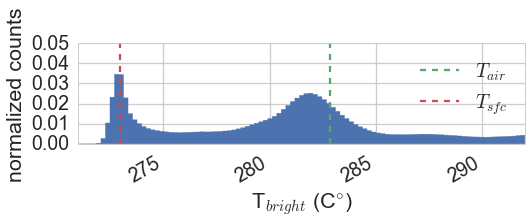

In [10]:
bright1d = (brightTemp.isel(time=(slice(350,400))).values.flatten()) - .8
# bright1d = brightTemp.values.flatten() - 1.5

# Histogram - counts and bins
fig, ax = plt.subplots(1,1,figsize=(8, 2))
cmin = 273 - 2
cmax = 273 + 19
tsp = np.linspace(cmin, cmax, 100)
weights = np.ones_like(bright1d) / float(len(bright1d))
counts, bins, m = ax.hist(bright1d + 273, bins=tsp,
                          normed=False, fill=True,
                          histtype='step', weights=weights)


# Surface and air temperature
d = cameraLocDataset.time[0]
airTemp = support.T6.sel(time=d, method='nearest').values + 273
sfcTemp = support.Tsrf.sel(time=d, method='nearest').values + 273
ax.plot([airTemp, airTemp], [0, .25], '--', label='$T_{air}$')
ax.plot([sfcTemp, sfcTemp], [0, .25], '--', label='$T_{sfc}$')

ax.set_xlim(cmin, cmax)
ax.set_ylim(0, 0.05)
ax.set_xlabel('T$_{bright}$ (C$^{\circ}$)')
ax.set_ylabel('normalized counts')
fig.autofmt_xdate()
# ax.text(sfcTemp + 0.75, 0.045, '$T_{sfc}$')
# ax.text(airTemp + 0.75, 0.045, '$T_{air}$')
ax.legend(loc='upper right')

os.chdir(dirPrint)
fig.savefig('SNQ.Tsurf_Flights.pdf')

In [81]:
print(airTemp)

282.853333333
